In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformed_data as td
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy import inspect
from urllib.parse import quote_plus
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, select
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from bioinfokit.analys import stat

In [12]:
cryptocurrencies_df = td.TransformedData.cryptocurrencies_df.copy()
crypto_tag_df = td.TransformedData.crypto_tag_df.copy()
tags_df = td.TransformedData.tags_df.copy()
crypto_daily_history_df = td.TransformedData.crypto_daily_history_df.copy()

In [13]:
t1 = pd.merge(cryptocurrencies_df, crypto_tag_df, on='crypto_id', how='inner')
t2 = pd.merge(t1, tags_df, on='tag_id', how='inner')
t3 = t2.loc[t2.tag_name == 'Mineable']
t4 = pd.merge(t3, crypto_daily_history_df, on='crypto_id', how='inner')
minable_coins_volumes = t4.loc[:, ['volume']]
minable_coins_volumes

,volume
0,1.068064e+10
1,8.962525e+09
2,1.010039e+10
3,1.720286e+10
4,2.018100e+10
...,...
8367,1.268417e+07
8368,1.956765e+07
8369,1.218683e+07
8370,1.484313e+07


##### Descriptive Statistics, Part 3:
    Plot the 24h daily volume distribution of 'Mineable' cryptocurrencies.

In [14]:
# low volumes
low_volumes = minable_coins_volumes.loc[minable_coins_volumes.volume < 2e9, 'volume'].values.tolist()
low_volumes = [0] + low_volumes + [2e9]

# middle volumes
middle_volumes = minable_coins_volumes.loc[(minable_coins_volumes.volume <= 60e9) & (minable_coins_volumes.volume >= 2e9), 'volume'].values.tolist()
middle_volumes = [0] + middle_volumes + [60e9]

# high volumes
high_volumes = minable_coins_volumes.loc[minable_coins_volumes.volume > 60e9, 'volume'].values.tolist()
high_volumes = high_volumes

([<matplotlib.axis.XTick at 0x7f9965c5bbb0>,
 [Text(0.0, 0, '0'),
  Text(400000000.0, 0, '0.4B'),
  Text(800000000.0, 0, '0.8B'),
  Text(1200000000.0, 0, '1.2B'),
  Text(1600000000.0, 0, '1.6B'),
  Text(2000000000.0, 0, '2B')])

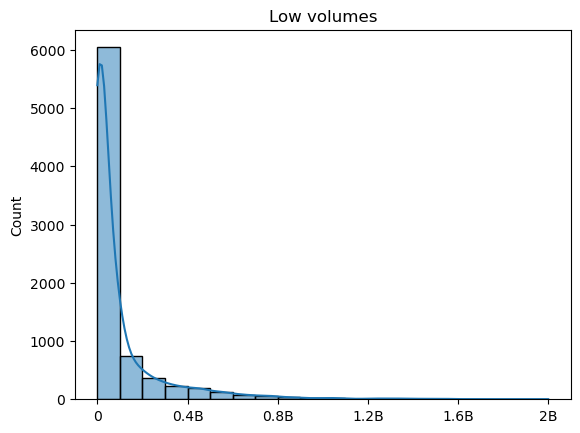

In [15]:
sns.histplot(low_volumes, bins=20, alpha=0.5, kde=True)
plt.title('Low volumes')
plt.xticks([0, 0.4e9, 0.8e9, 1.2e9, 1.6e9, 2e9], ['0', '0.4B', '0.8B', '1.2B', '1.6B', '2B'])

Text(0.5, 1.0, 'Middle volumes')

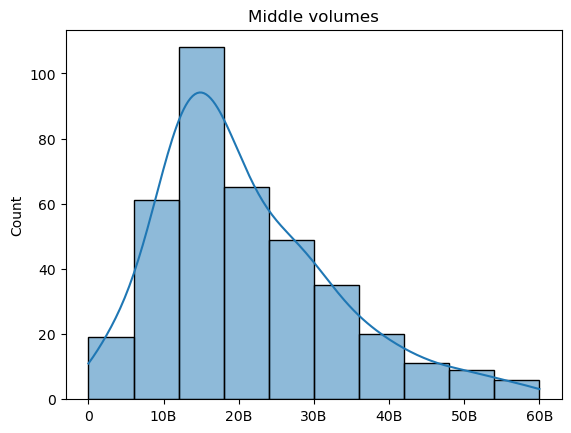

In [16]:
sns.histplot(middle_volumes, bins=10, alpha=0.5, kde=True)
plt.xticks([0, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9], ['0', '10B', '20B', '30B', '40B', '50B', '60B'])
plt.title('Middle volumes')

Text(0.5, 1.0, 'High volumes')

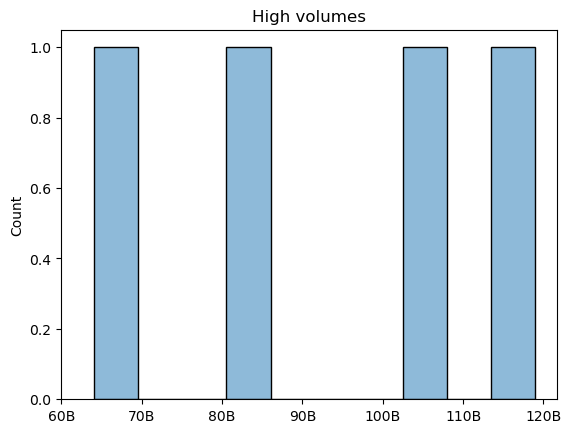

In [17]:
sns.histplot(high_volumes, bins=10, alpha=0.5)
plt.xticks([60e9, 70e9, 80e9, 90e9, 100e9, 110e9, 120e9], ['60B', '70B', '80B', '90B', '100B', '110B', '120B'])
plt.title('High volumes')

In [18]:
temp_table = pd.merge(cryptocurrencies_df, crypto_daily_history_df, on='crypto_id', how='inner')
cryptoname_volume = temp_table.loc[:, ['crypto_name', 'volume']]
cryptoname_volume

,crypto_name,volume
0,Bitcoin,1.068064e+10
1,Bitcoin,8.962525e+09
2,Bitcoin,1.010039e+10
3,Bitcoin,1.720286e+10
4,Bitcoin,2.018100e+10
...,...,...
70368,Amp,4.195519e+06
70369,Amp,7.100231e+06
70370,Amp,7.168563e+06
70371,Amp,6.512543e+06


##### Inferential Statistics:
    Consider the three currencies 'Bitcoin', 'Ethereum', 'Tether USDt' and check whether the following claim is correct or not?
    "The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is much higher than the average daily trading volume of other cryptocurrencies."

In [19]:
# Perform t-test

# H-null: The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is not much higher than the average daily trading volume of other cryptocurrencies."
# H-alt: The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is much higher than the average daily trading volume of other cryptocurrencies."

# Define Group 1 ('Bitcoin,' 'Ethereum,' and 'Tether USDt')
group1 = ['Bitcoin', 'Ethereum', 'Tether USDt']

# Filter data for Group 1
group1_data = cryptoname_volume.loc[cryptoname_volume['crypto_name'].isin(group1), 'volume']

# Filter data for Group 2 (others)
group2_data = cryptoname_volume.loc[~cryptoname_volume['volume'].isin(group1), 'volume']

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False)

# Define significance level
alpha = 0.01

# Interpret the results
if p_value < alpha:
    print("p-value (={}) is far less than alpha (={}).".format(p_value, alpha))
    print("Reject the null hypothesis.")
    print("The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is significantly much higher than the average daily trading volume of other cryptocurrencies.")
else:
    print("p-value (={}) is graater than alpha (={}).".format(p_value, alpha))
    print("Fail to reject the null hypothesis.")
    print("No significant difference in average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' and average daily trading volume of other cryptocurrencies.")


p-value (=4.960064018232957e-230) is far less than alpha (=0.01).
Reject the null hypothesis.
The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is significantly much higher than the average daily trading volume of other cryptocurrencies.


##### Conlusion:
    p-value (=4.960064018232957e-230) is far less than alpha (=0.01) so,
    The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is significantly much higher than the average daily trading volume of other cryptocurrencies.


In [20]:
import warnings
warnings.filterwarnings("ignore")


# Perform one-way ANOVA

# H-null: All groups have the same mean daily trading volume
# H-alt: At least one group has a different mean daily trading volume

model = sm.formula.ols('volume ~ crypto_name', data=cryptoname_volume).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Define significance level
alpha = 0.01

# Interpret the results
if anova_table['PR(>F)'][0] < alpha:
    print("Reject the null hypothesis.")
    print("At least one group has a different mean daily trading volume.")
    
    # Perform multiple pairwise comparison (Tukey's HSD)
    print("*******************************************************")
    print("Performing multiple pairwise comparison (Tukey's HSD): ")
    res = stat()
    res.tukey_hsd(df=cryptoname_volume, res_var='volume', xfac_var='crypto_name', anova_model='volume ~ crypto_name')
    pairwise_talbe = res.tukey_summary.loc[
        (res.tukey_summary.group1 == 'Bitcoin') | 
        (res.tukey_summary.group1 == 'Ethereum') | 
        (res.tukey_summary.group1 == 'Tether USDt'),
        ['group1', 'group2', 'p-value']
    ]
    
    pairwise_talbe['reject'] = pairwise_talbe.loc[:, 'p-value'] < alpha
    print(pairwise_talbe)
    
    if pairwise_talbe['reject'].all():    
        print(
            "Conclusion:", 
                    "1. The average daily trading volume of 'Bitcoin' is significantly far higher than the average daily trading volume of any other cryptocurrencies.",
                    "2. The average daily trading volume of 'Ethereum' is significantly far higher than the average daily trading volume of any other cryptocurrencies.", 
                    "3. The average daily trading volume of 'Tether USDt' is significantly far higher than the average daily trading volume of any other cryptocurrencies.",
                    sep="\n"
        )
    
else:
    print("Fail to reject the null hypothesis.")
    print("No significant difference in average daily trading volume among groups.")


Reject the null hypothesis.
At least one group has a different mean daily trading volume.
*******************************************************
Performing multiple pairwise comparison (Tukey's HSD): 
          group1             group2  p-value  reject
0        Bitcoin           Ethereum    0.001    True
1        Bitcoin        Tether USDt    0.001    True
2        Bitcoin                BNB    0.001    True
3        Bitcoin                XRP    0.001    True
4        Bitcoin           USD Coin    0.001    True
..           ...                ...      ...     ...
589  Tether USDt           PlayDapp    0.001    True
590  Tether USDt      Pundi X (New)    0.001    True
591  Tether USDt  Vulcan Forged PYR    0.001    True
592  Tether USDt             Status    0.001    True
593  Tether USDt                Amp    0.001    True

[594 rows x 4 columns]
Conclusion:
1. The average daily trading volume of 'Bitcoin' is significantly far higher than the average daily trading volume of any othe

##### Conlusion:
1. The average daily trading volume of 'Bitcoin' is significantly far higher than the average daily trading volume of any other cryptocurrencies.

2. The average daily trading volume of 'Ethereum' is significantly far higher than the average daily trading volume of any other cryptocurrencies.

3. The average daily trading volume of 'Tether USDt' is significantly far higher than the average daily trading volume of any other cryptocurrencies.